In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [63]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    lags = len(y)//2 - 1
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, method='ywm')

        plt.tight_layout()
    return

# Отображение графика

In [8]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

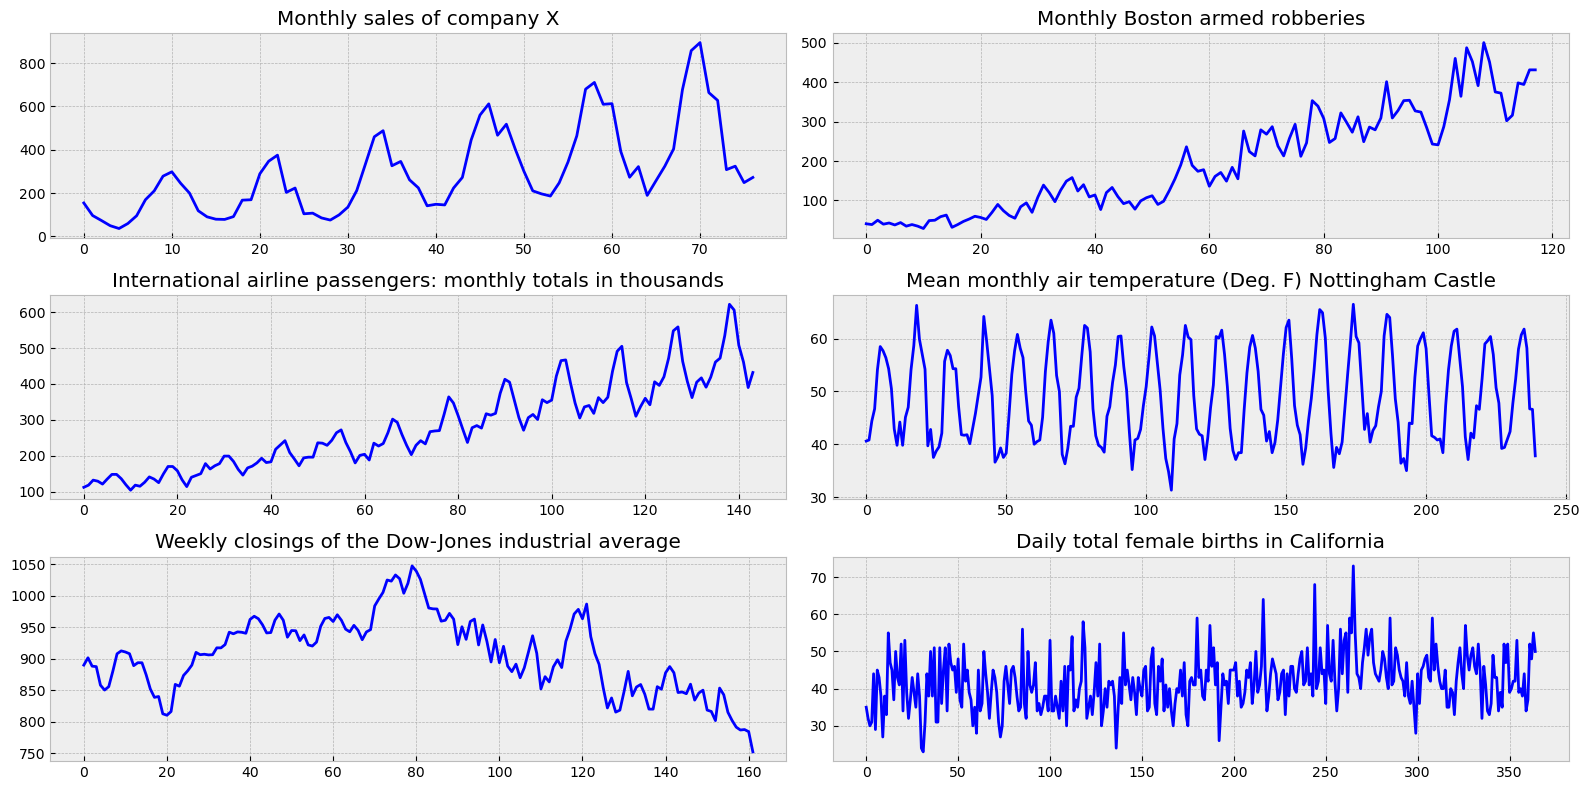

In [9]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Нормализуем дисперсию

In [10]:
from scipy.stats import boxcox

In [11]:
all_series_boxcox = {}
for series in all_series.items():
    all_series_boxcox[series[0]] = boxcox(pd.Series(series[1]), 0)

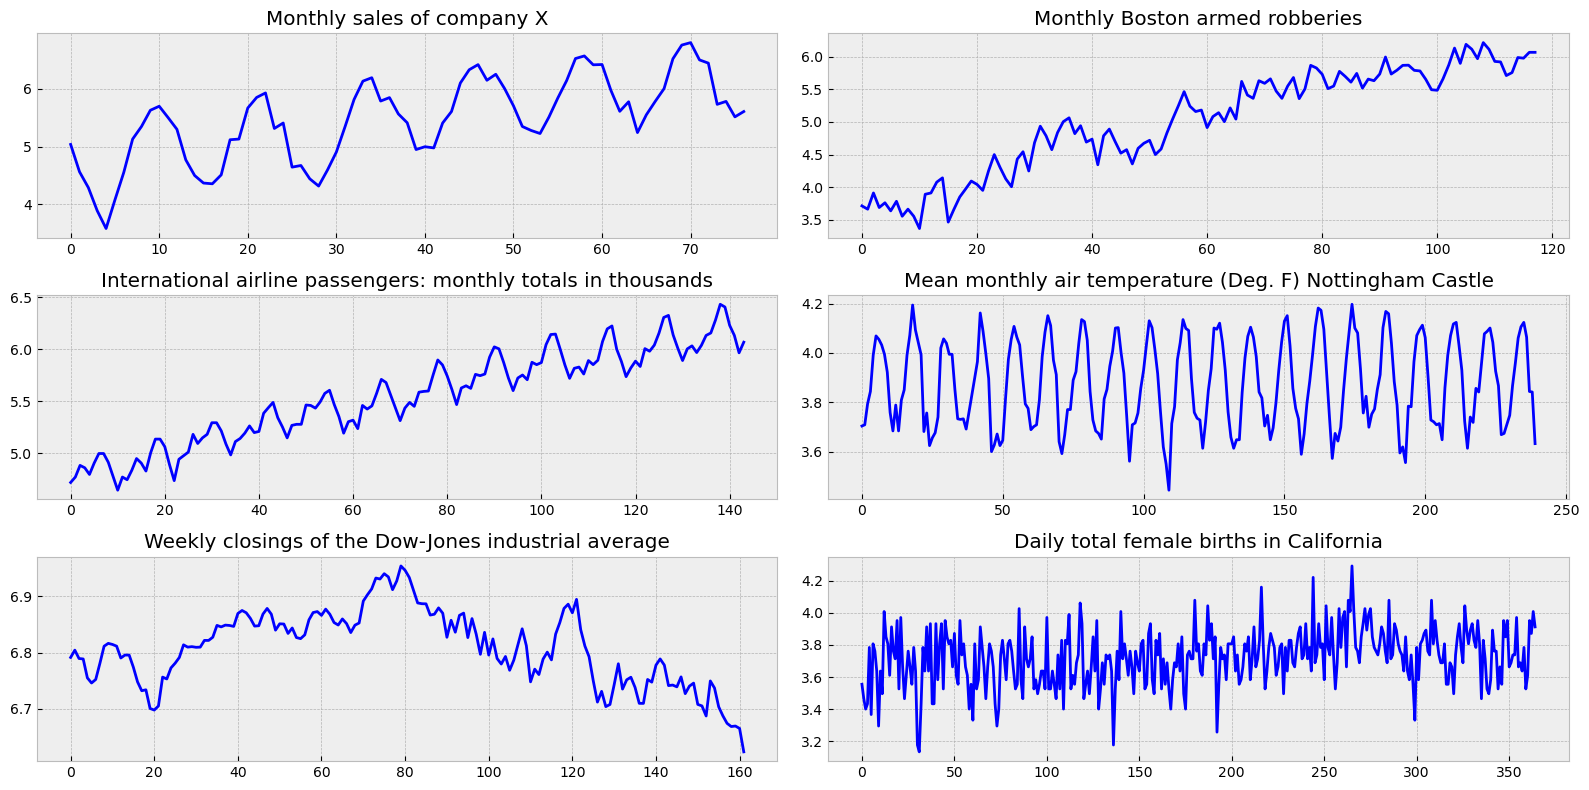

In [12]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series_boxcox.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        plt.plot(all_series_boxcox[key], color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Дифференцируем 

In [13]:
import numpy as np

In [14]:
all_series_diff = {}
for series in all_series_boxcox.items():
    all_series_diff[series[0]] = np.diff(pd.Series(series[1]), 1)

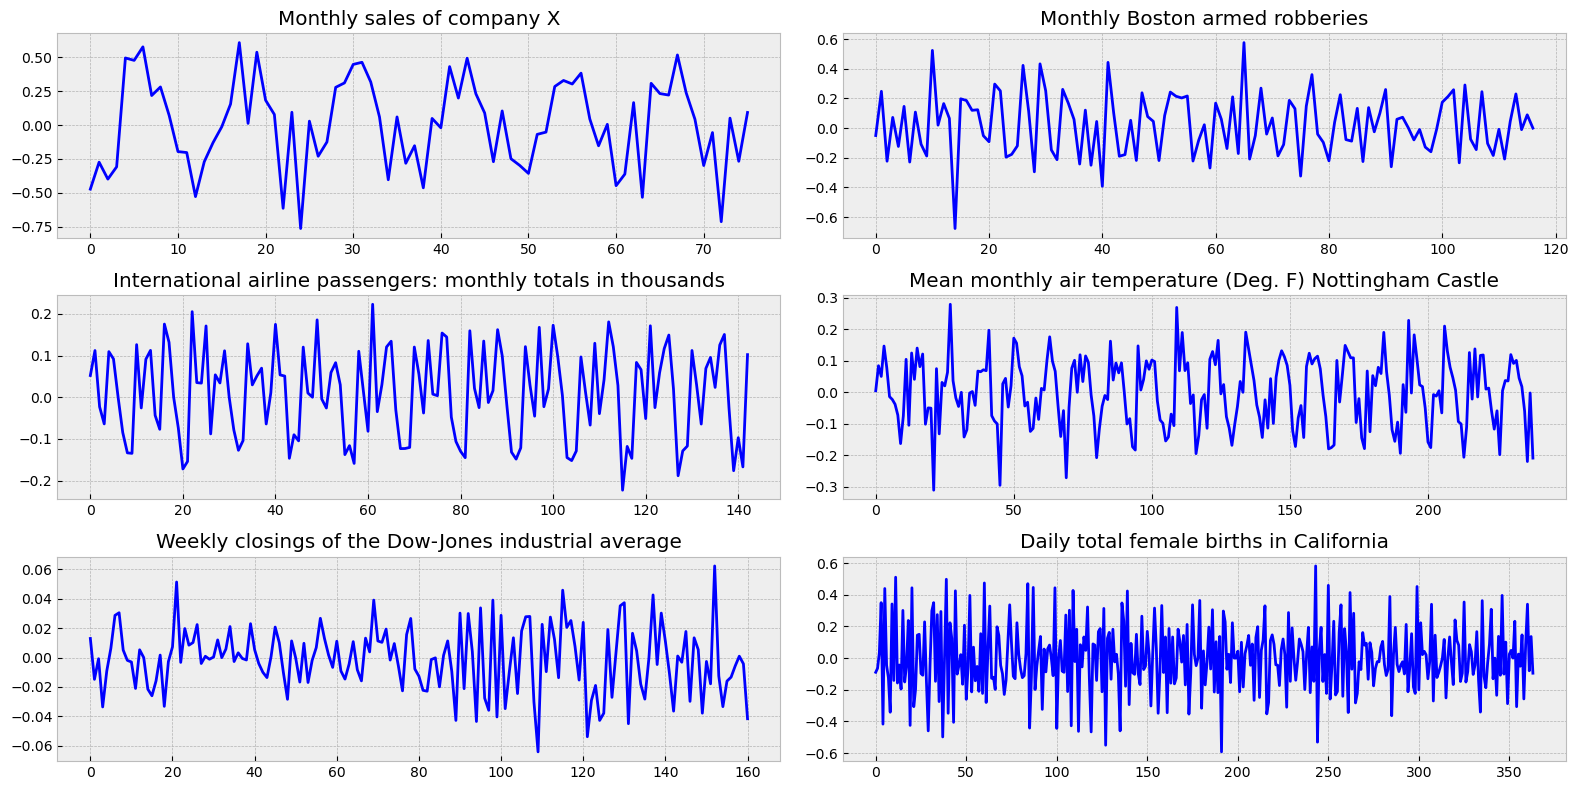

In [15]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series_diff.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        plt.plot(all_series_diff[key], color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

# Тест Дики-Фуллера 

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128

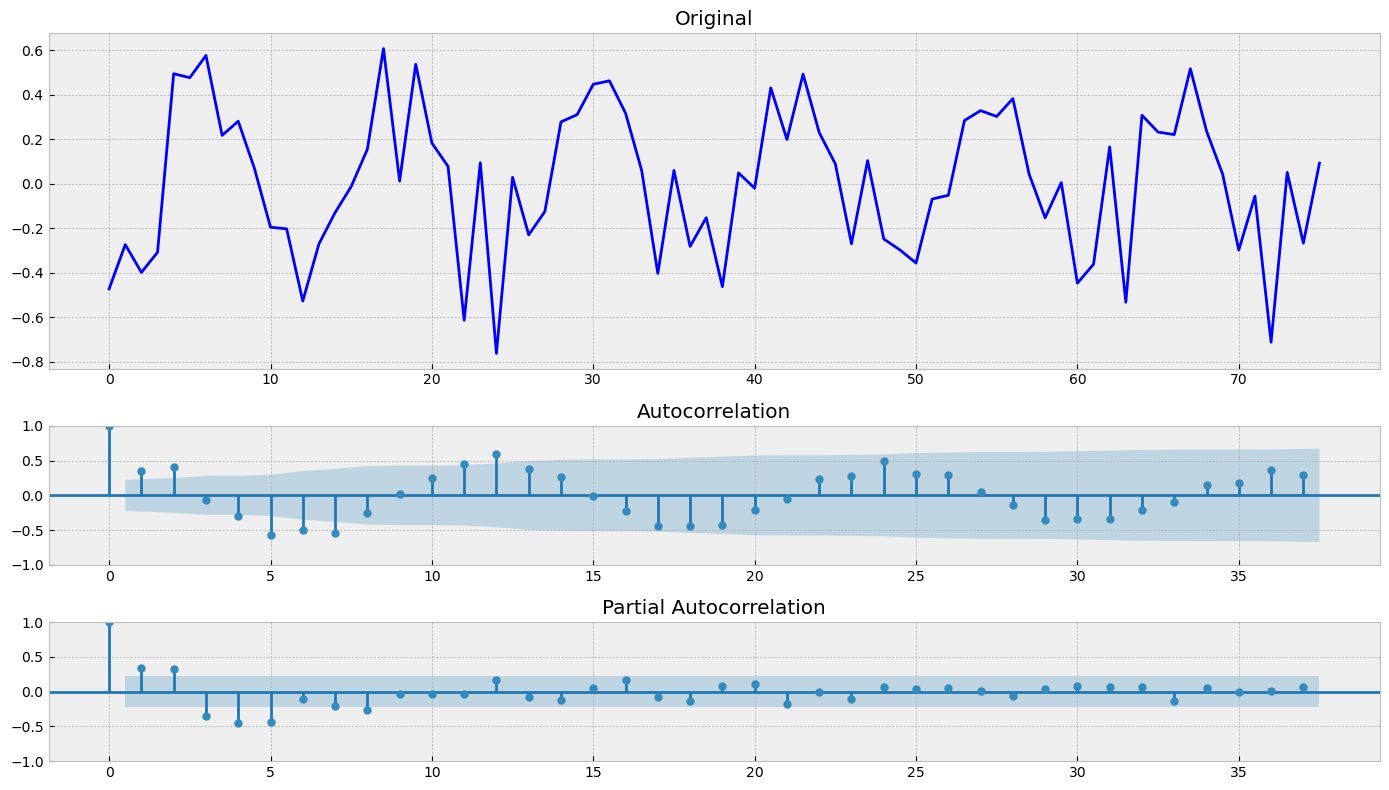

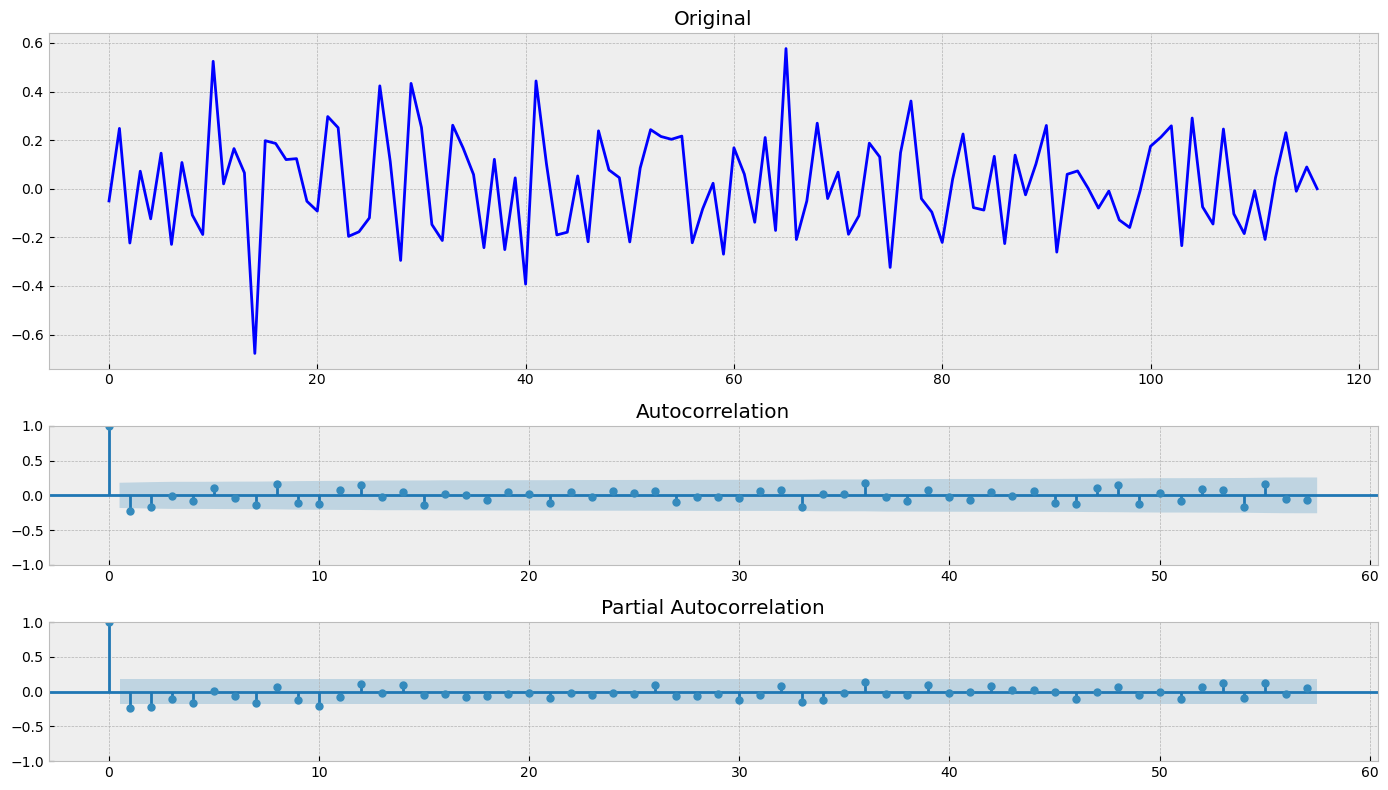

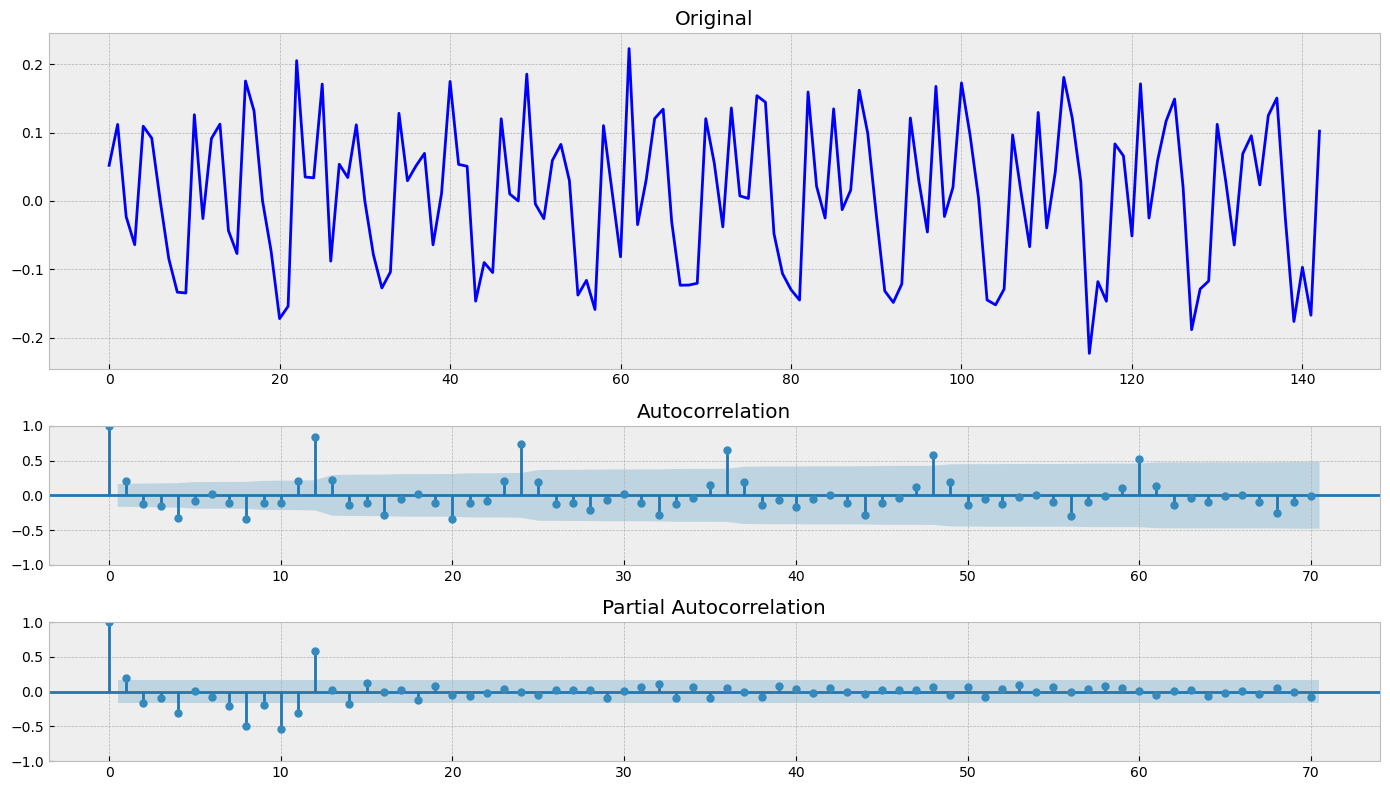

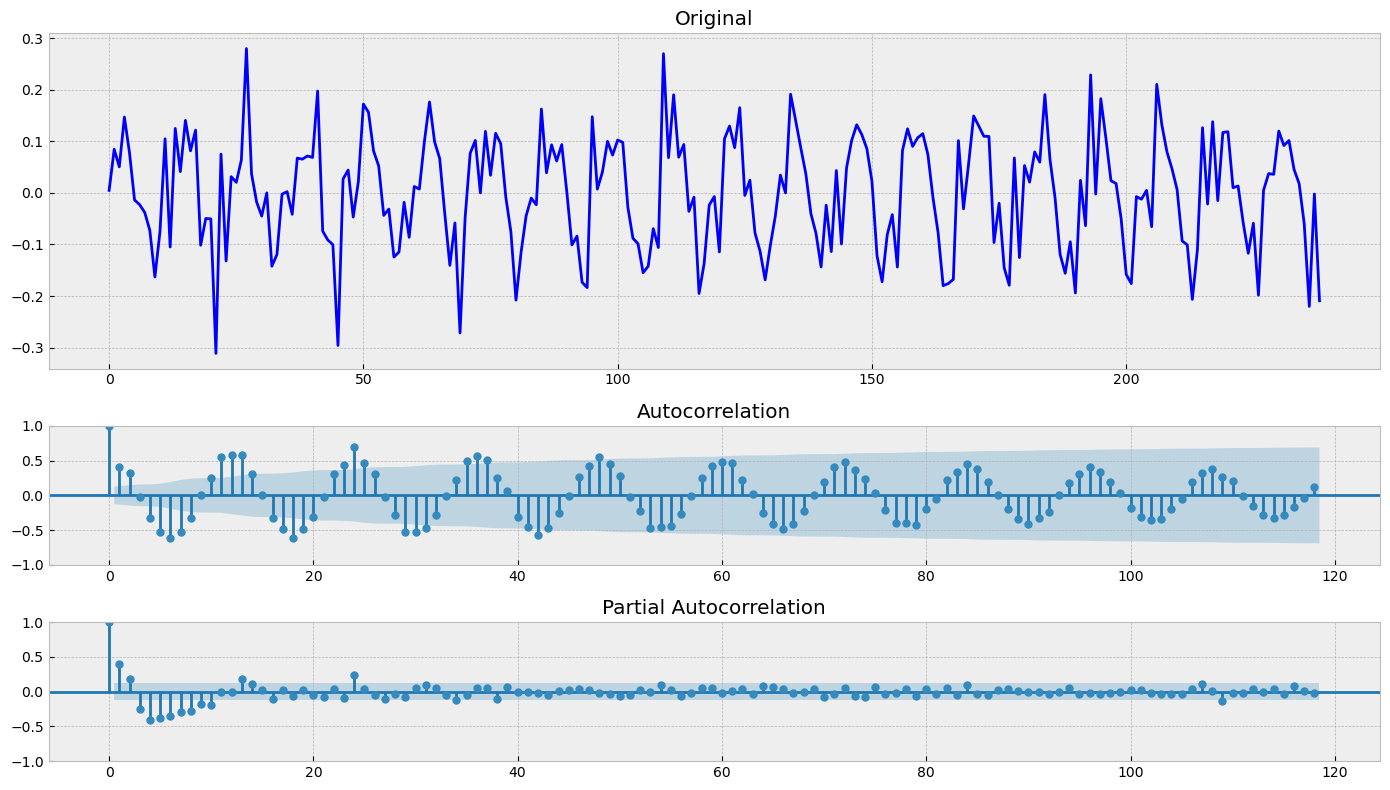

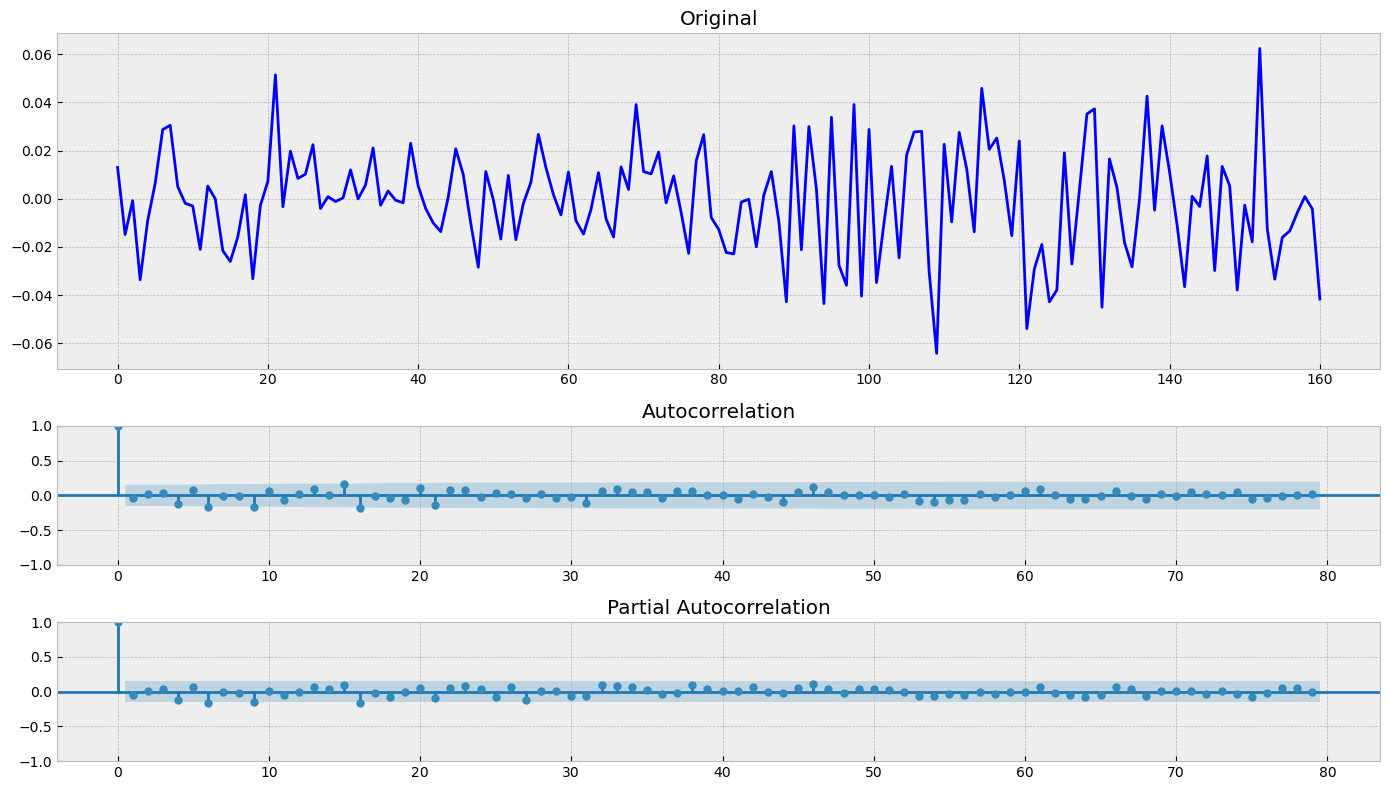

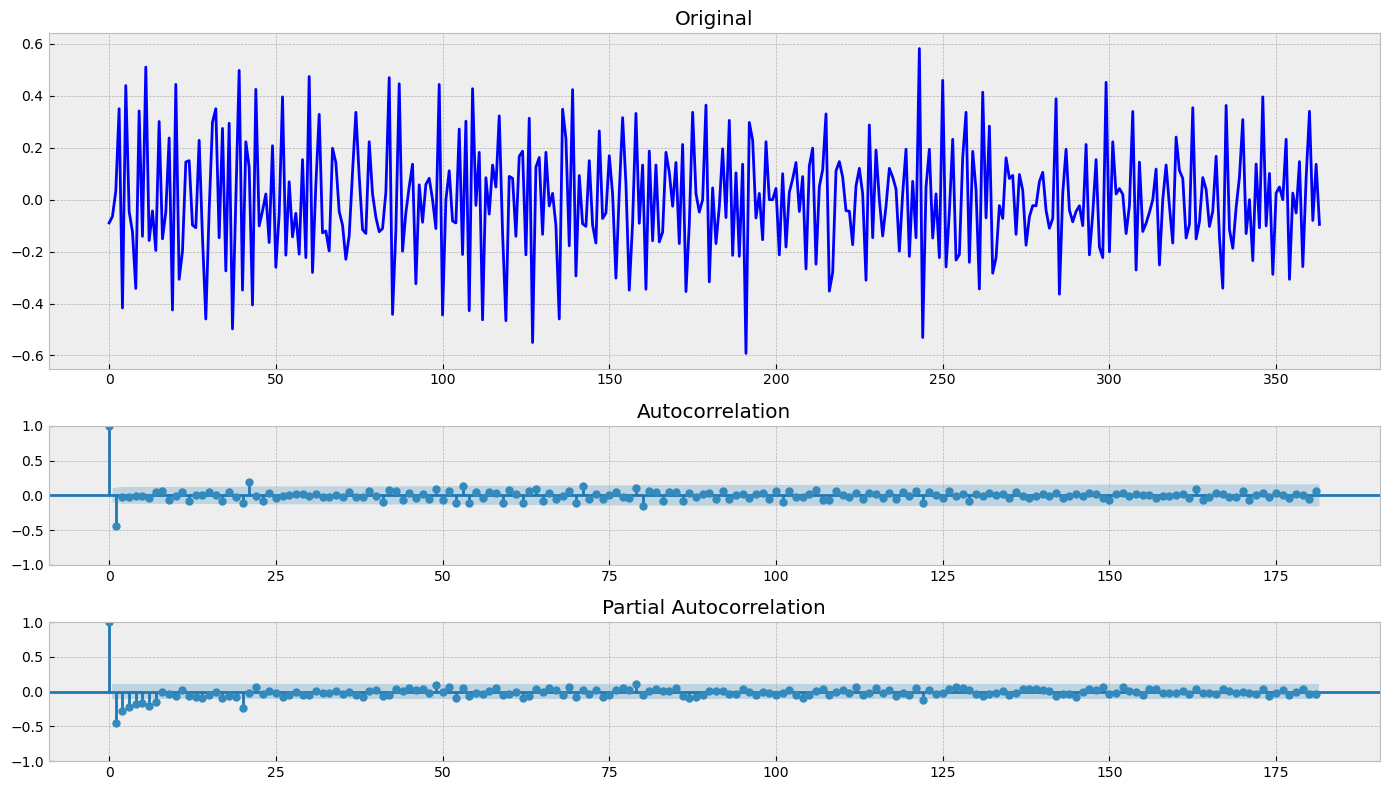

In [64]:
for series in all_series_diff.items():
    print(series[0])
    tsplot(series[1])
    print()

International airline passengers: monthly totals in thousands - не прошёл тест Дики-Фулера. Избавимся от сезонности.

Mean monthly air temperature (Deg. F) Nottingham Castle - здесь также наблюдаем сезонность. Хотя тест Дикки-Фулера почему-то проходит. Избавимся от неё. 

Monthly sales of company X - здесь тоже явно присутствует сезонность. Но при попытке избавиться от неё тест Дикки-Фулера мы перестаем проходить. Так что, оставляем так.

In [67]:
all_series_season = {}
for series in all_series_diff.items():
    if series[0] in ['International airline passengers: monthly totals in thousands', 'Mean monthly air temperature (Deg. F) Nottingham Castle']:
        all_series_season[series[0]] = series[1][12:] - series[1][:-12]
    else:
        all_series_season[series[0]] = series[1]

Monthly sales of company X
Results of Dickey-Fuller Test:
Test Statistic                 -3.135644
p-value                         0.024025
#Lags Used                     11.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64

Monthly Boston armed robberies
Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64

International airline passengers: monthly totals in thousands
Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118

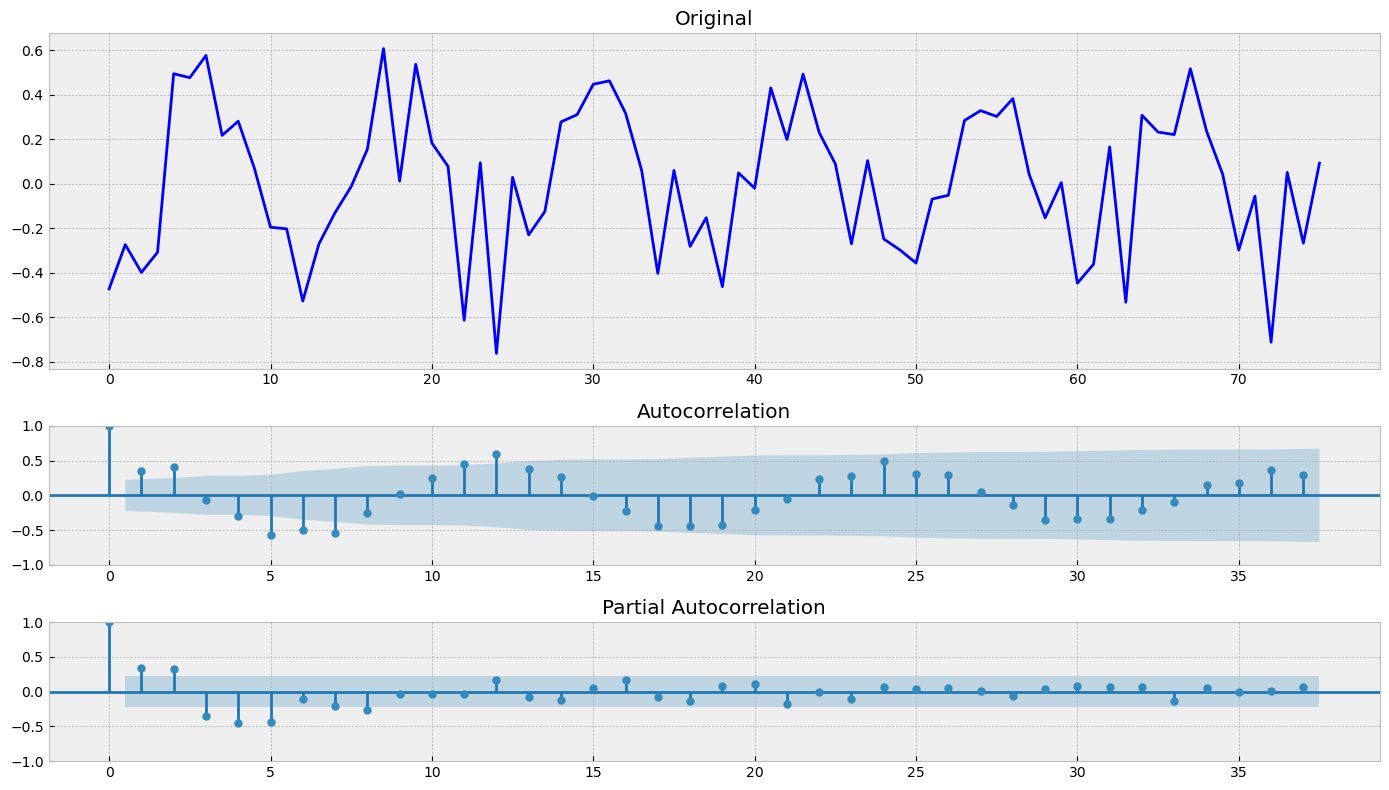

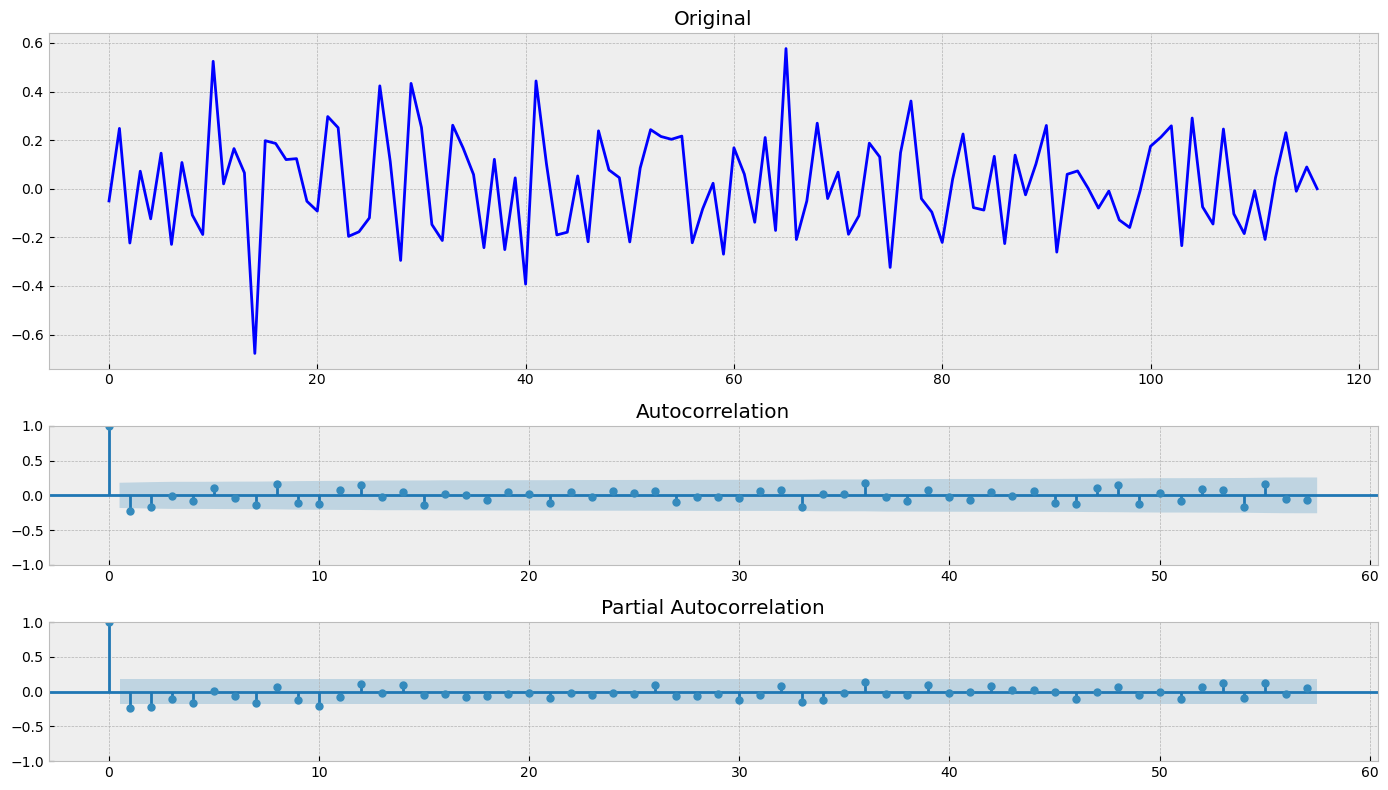

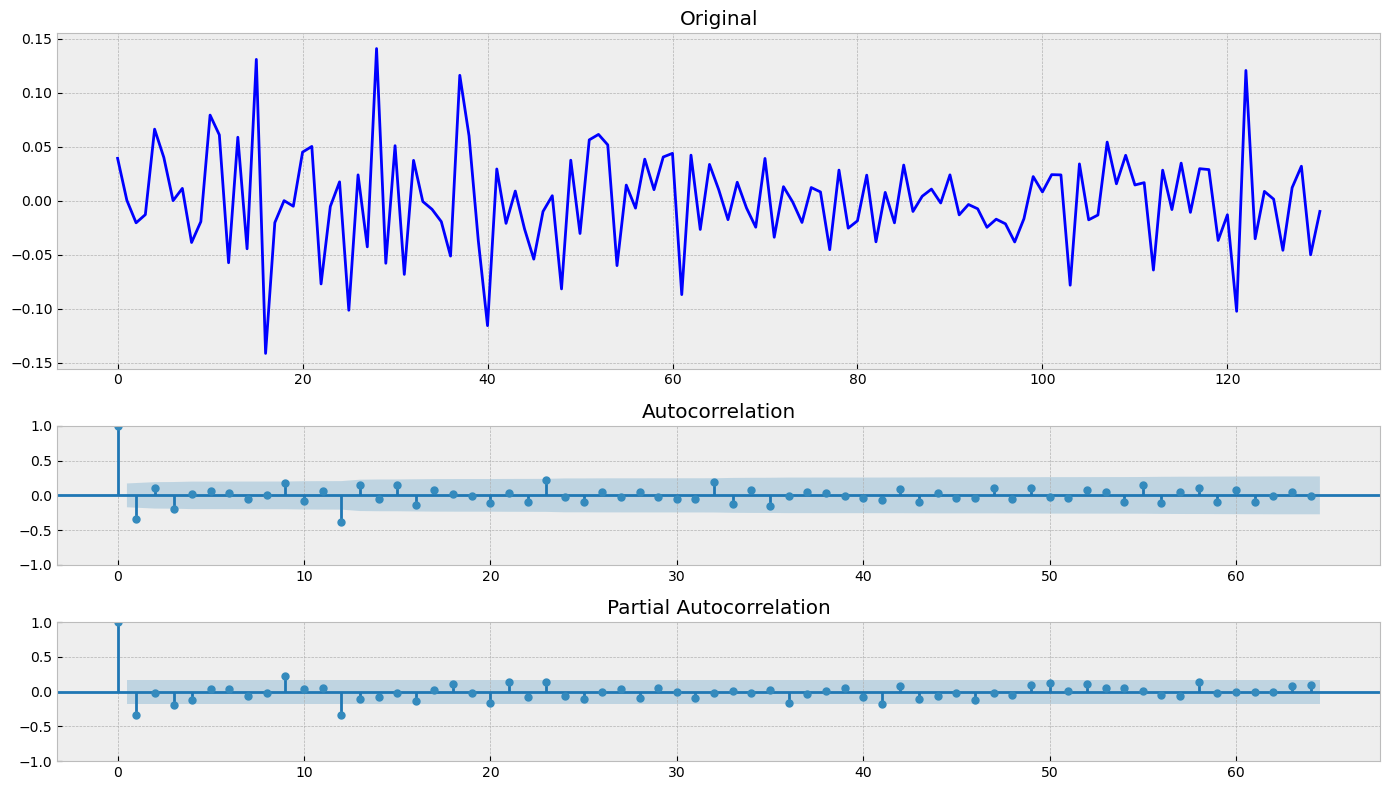

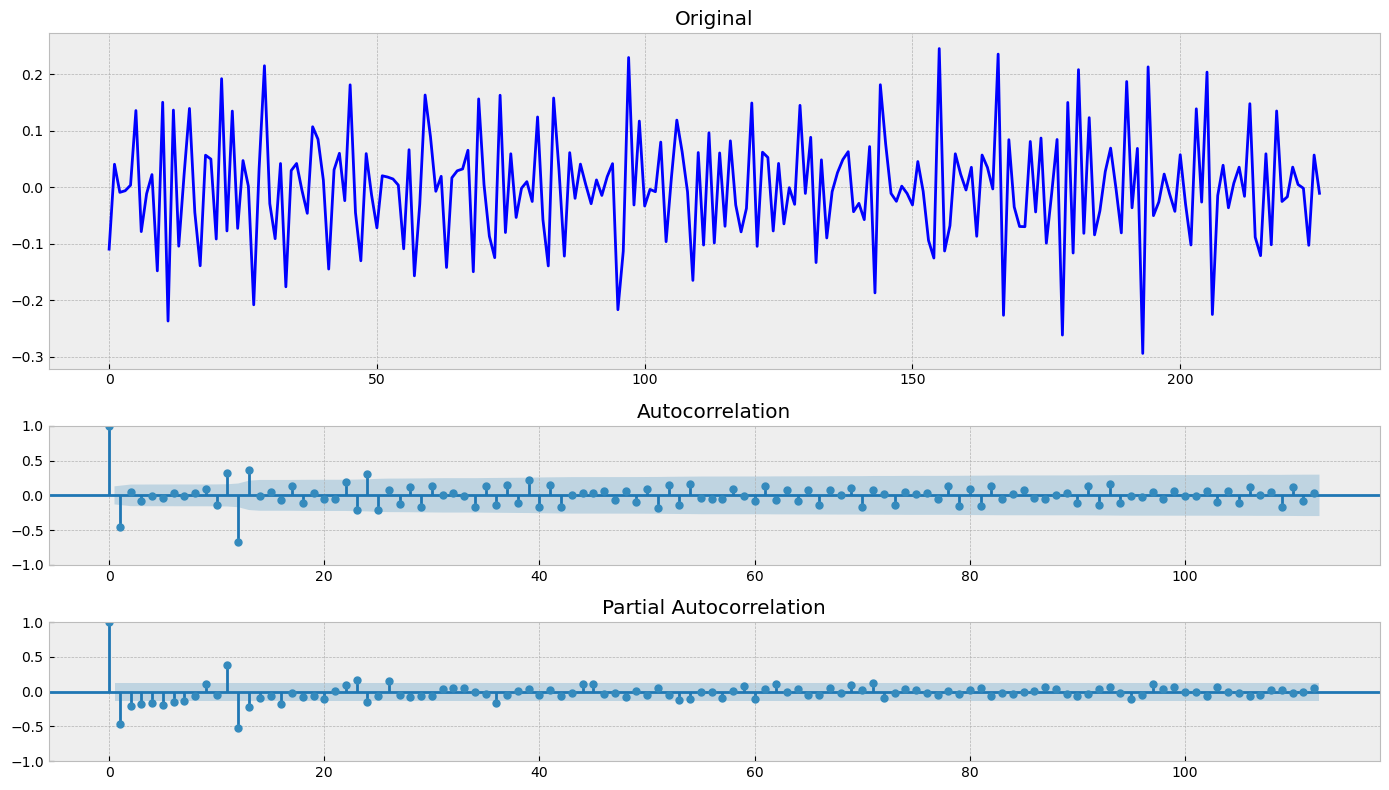

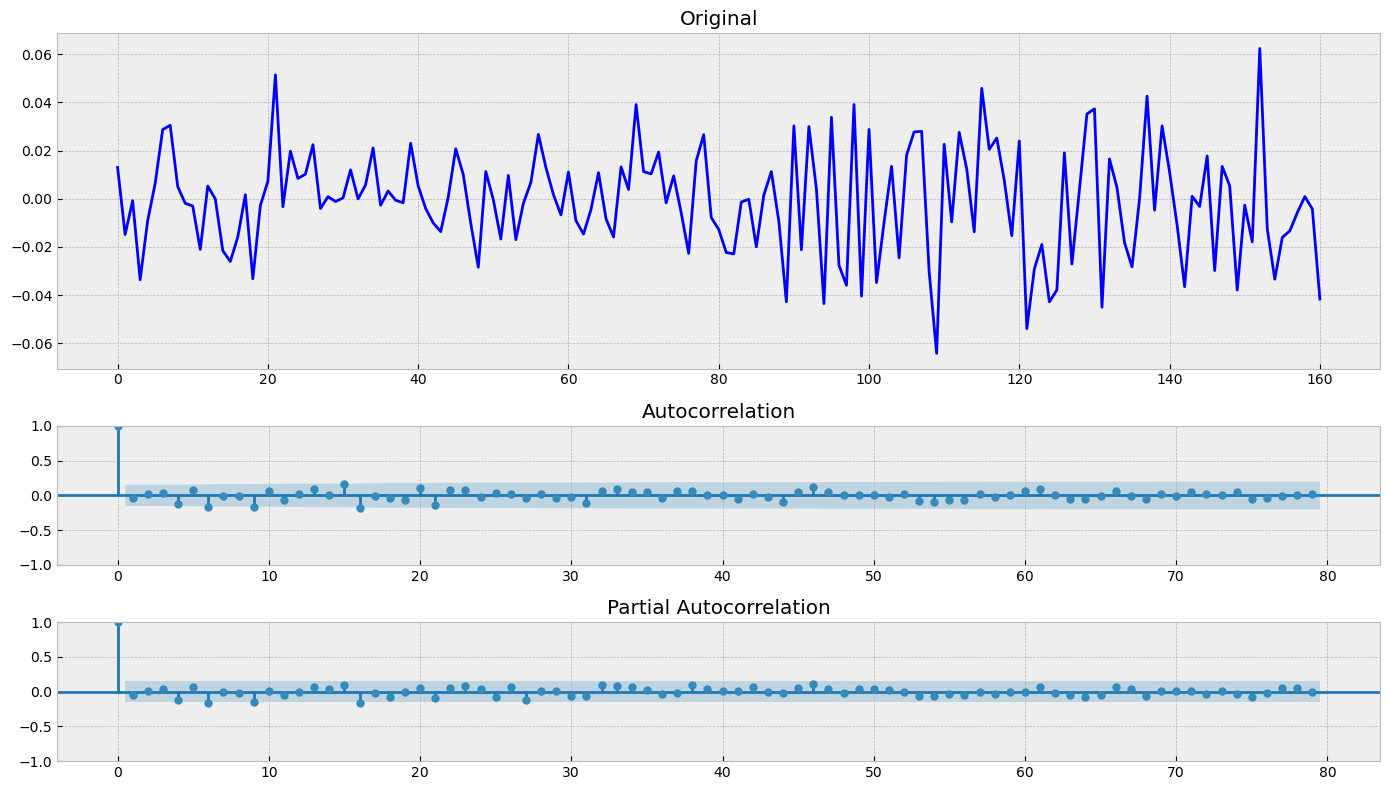

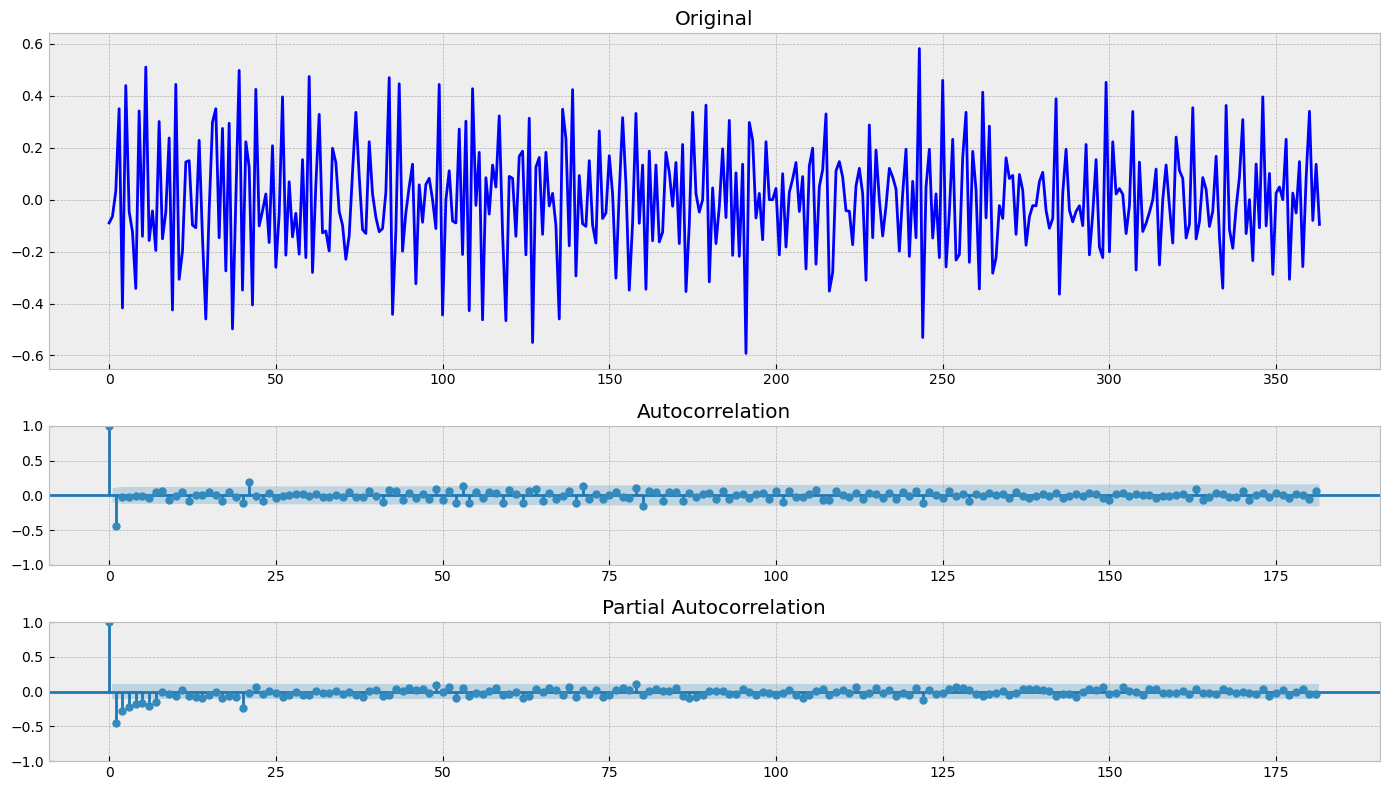

In [68]:
for series in all_series_season.items():
    print(series[0])
    tsplot(series[1])
    print()

Везде прошли тест Дикки-Фулера. На уровне значимости 0.05 все ряды приведены к стационарному виду.